In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [6]:
# Load datasets
customers = pd.read_csv('Dataset/Customers.csv')
transactions = pd.read_csv('Dataset/Transactions.csv')
products = pd.read_csv('Dataset/Products.csv')

In [14]:
# Merge transactions and products, handling duplicate columns
merged_data = pd.merge(transactions, products, on='ProductID', suffixes=('_transactions', '_products'))
merged_data.drop(columns=['Price_transactions'], inplace=True)  # Drop the Price column from transactions
merged_data.rename(columns={'Price_products': 'Price'}, inplace=True)  # Rename the Price column from products

# Merge with customers
merged_data = pd.merge(merged_data, customers, on='CustomerID')

# Verify column names
print("Merged Data Columns:", merged_data.columns)


Merged Data Columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'ProductName', 'Category', 'Price',
       'CustomerName', 'Region', 'SignupDate'],
      dtype='object')


In [16]:
# Create customer profiles
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean',      # Average product price
    'Region': 'first',    # Customer region
    'SignupDate': 'first' # Signup date
}).reset_index()

# Convert SignupDate to tenure (days since signup)
customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['Tenure'] = (pd.Timestamp.now() - customer_profiles['SignupDate']).dt.days

# Drop SignupDate (no longer needed)
customer_profiles.drop(columns=['SignupDate'], inplace=True)

# One-hot encode categorical features (Region)
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'Price', 'Tenure']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

# Drop CustomerID (not needed for clustering)
customer_profiles.drop(columns=['CustomerID'], inplace=True)

In [22]:
# Create customer profiles
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean',      # Average product price
    'Region': 'first',    # Customer region
    'SignupDate': 'first' # Signup date
}).reset_index()

# Convert SignupDate to tenure (days since signup)
customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['Tenure'] = (pd.Timestamp.now() - customer_profiles['SignupDate']).dt.days

# Drop SignupDate (no longer needed)
customer_profiles.drop(columns=['SignupDate'], inplace=True)

# One-hot encode categorical features (Region)
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Inspect the customer profiles
print(customer_profiles.head())

  CustomerID  TotalValue  Quantity       Price  Tenure  Region_Europe  \
0      C0001     3354.52        12  278.334000     929          False   
1      C0002     1862.74        10  208.920000    1076          False   
2      C0003     2725.38        14  195.707500     323          False   
3      C0004     5354.88        23  240.636250     838          False   
4      C0005     2034.24         7  291.603333     893          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


In [24]:
from sklearn.preprocessing import StandardScaler

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'Price', 'Tenure']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])


In [26]:
# Create customer profiles
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean',      # Average product price
    'Region': 'first',    # Customer region
    'SignupDate': 'first' # Signup date
}).reset_index()

# Convert SignupDate to tenure (days since signup)
customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['Tenure'] = (pd.Timestamp.now() - customer_profiles['SignupDate']).dt.days

# Drop SignupDate (no longer needed)
customer_profiles.drop(columns=['SignupDate'], inplace=True)

# One-hot encode categorical features (Region)
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'Price', 'Tenure']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

# Drop CustomerID (not needed for clustering)
customer_profiles.drop(columns=['CustomerID'], inplace=True)

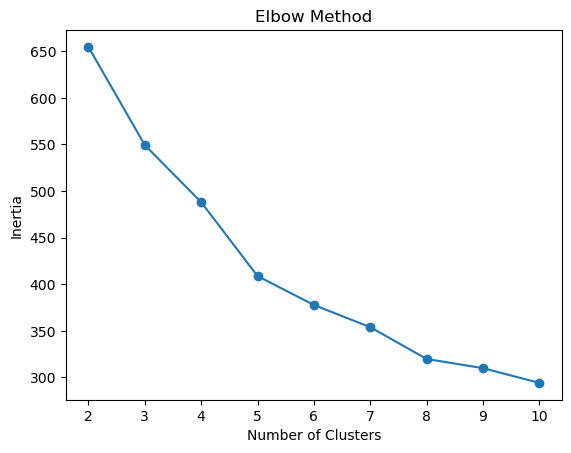

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profiles)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [30]:
# Choose optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles)

In [32]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index
db_index = davies_bouldin_score(customer_profiles.drop(columns=['Cluster']), customer_profiles['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Other metrics (optional)
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(customer_profiles.drop(columns=['Cluster']), customer_profiles['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Davies-Bouldin Index: 1.55
Silhouette Score: 0.20


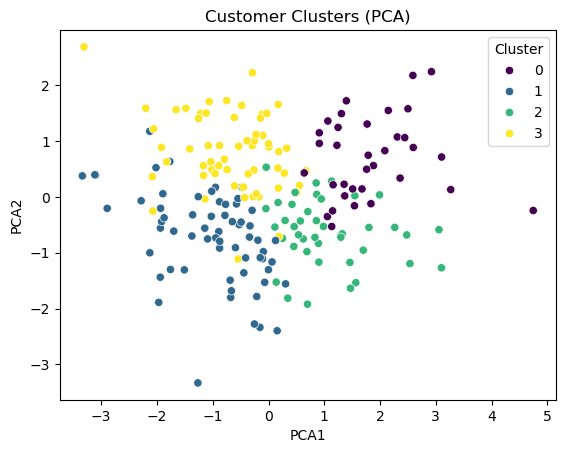

In [34]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_profiles.drop(columns=['Cluster']))

# Add PCA results to DataFrame
customer_profiles['PCA1'] = pca_result[:, 0]
customer_profiles['PCA2'] = pca_result[:, 1]

# Plot clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_profiles, palette='viridis')
plt.title('Customer Clusters (PCA)')
plt.show()